<a href="https://colab.research.google.com/github/garrettdevereux/ComputerVisionFinal/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Final Project: Sports Image Classification
## Garrett Devereux, University of Washington CSE 455

Classifiction project utilizing the [Kaggle Sports Images](https://www.kaggle.com/datasets/gpiosenka/sports-classification?resource=download) dataset. This notebook implements and trains 5 different models on the dataset using a variety of techniques and then compares and contrasts the models on a validation set as well as real world images.

## Import Necessary Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading the Dataset

Connect to Google Drive to load dataset. This project was built inside a Google Drive folder 'Final' with the datset located in the subdirectory 'Final/sportsImages'. If you have downloaded this from the Github Repo, you will have to change the file paths below to reflect the new file structure.

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Store the current directory as 'Final' so we can refer to future files as if we are already in the directory. Update checkpoints to the directory where we will store and save all of the trained models.

In [4]:
os.chdir("/content/drive/MyDrive/CSE 455/Final")
checkpoints = "/content/drive/MyDrive/CSE 455/Final/sportsImages/models/"

If correctly mounted, should see 'Final Project.ipynb' and 'sportsImages' in the current directory, and 'class_dict.csv', 'models', 'realworld', 'test', 'train', and 'valid' in 'sportsImages' directory.

In [ ]:
!ls; ls sportsImages

 DatasetExample.png  'Final Project.ipynb'   FirstTryGraphs   sportsImages
class_dict.csv	models	realworld  test  train	valid


### Data Augmentation
Here I used two sets of data augmentation for the five models. For the first three models, I used trasform_train on the test set which resizes the image, and then performs random crop, random horizontal flip, random rotation, and adds some noise to the image through AddGaussianNoise(). For the fourth and fifth model, I used transform_train_normalized which removs the rotation and noise, and instead normalizes the images with std and mean vectors

In [5]:
from matplotlib.colors import Normalize
# Method for further augmentation
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

std=torch.Tensor([0.4687, 0.4667, 0.4540])
mean=torch.Tensor([0.2792, 0.2717, 0.2852])

def get_sports_data(augmentation=0):
    # Data augmentation for train set
    transform_train = transforms.Compose([
        transforms.Resize(150), # crop images down to 150x150x3
        transforms.RandomCrop(150, padding=8, padding_mode='edge'), # Take 150x150 crops from padded images
        transforms.RandomHorizontalFlip(p=0.5),    # 50% of time flip image along y-axis
        # Introduce further augmentations for further accuracy
        transforms.RandomRotation(degrees=(-5, 5)), # Rotate the image up to 5 degrees
        transforms.ToTensor(),
        AddGaussianNoise(0.001, 0.0001) # Introcude a little bit of noise
    ])

    # Normalized augmentations for models 4 and 5
    transform_train_normalized = transforms.Compose([
        transforms.Resize(150), # crop images down to 150x150x3
        transforms.RandomCrop(150, padding=8, padding_mode='edge'), # Take 150x150 crops from padded images
        transforms.RandomHorizontalFlip(p=0.5),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        transforms.Normalize(mean,std) # Normalize images for pretrained
    ])

    # Data augmentation for test and realworld, just resize
    transform_test = transforms.Compose([
        transforms.Resize(150),
        transforms.ToTensor(),
        # transforms.Normalize(mean,std) # only for pretrain
    ])

    # Normalized training augmentation for models 4 and 5
    transform_test_normalized = transforms.Compose([
        transforms.Resize(150),
        transforms.ToTensor(),
        # transforms.Normalize(mean,std) # only for pretrain
    ])

    # Load training - Used batch_size 128 throughout the project
    trainset = torchvision.datasets.ImageFolder(root='sportsImages/train', transform=transform_train) # change transform for 4 and 5
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

    # Load testing
    testset = torchvision.datasets.ImageFolder(root='sportsImages/test', transform=transform_test) # change transform for 4 an 5
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

    # Load validation
    validationset = torchvision.datasets.ImageFolder(root='sportsImages/valid', transform=transform_test)
    validationloader = torch.utils.data.DataLoader(validationset, batch_size=1, shuffle=True, num_workers=2)

    # Load real world image set
    realset = torchvision.datasets.ImageFolder(root='sportsImages/realworld', transform=transform_test)
    realloader = torch.utils.data.DataLoader(realset, batch_size=1, shuffle=False, num_workers=2)

    # Store the classes in a dictionary
    classes_info = pd.read_csv('sportsImages/class_dict.csv')
    return {'train': trainloader, 'test': testloader, 'real_world': realloader, 'valid': validationloader, 'class_dict' : classes_info}

data = get_sports_data()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Understanding the Dataset

All of the relevant information about the possible sports categories and indexes are stored in 'class_dict'. As seen below, there are 100 different classes from air hockey to wingsuit flying in alphabetical order. Each class has a corresponding class_index, which allows us to easily map from a predicted index to a class name.

In [ ]:
print(data['class_dict'])

    class_index                  class  height  width  scale by
0             0             air hockey     150    150         1
1             1        ampute football     150    150         1
2             2                archery     150    150         1
3             3          arm wrestling     150    150         1
4             4           axe throwing     150    150         1
..          ...                    ...     ...    ...       ...
95           95             water polo     150    150         1
96           96          weightlifting     150    150         1
97           97  wheelchair basketball     150    150         1
98           98      wheelchair racing     150    150         1
99           99        wingsuit flying     150    150         1

[100 rows x 5 columns]


If our model predicts a class_index of 45, we can easily get the class name with:

In [17]:
print(data['class_dict']['class'][42])

horse jumping


As we can see by our loaded train and test data, our train contains 13,572 different images, and our test contains 500 images.

In [ ]:
print(data['train'].__dict__)
print(data['test'].__dict__)

{'dataset': Dataset ImageFolder
    Number of datapoints: 13572
    Root location: sportsImages/train
    StandardTransform
Transform: Compose(
               Resize(size=150, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(150, 150), padding=8)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               AddGaussianNoise(mean=0.01, std=0.008)
           ), 'num_workers': 2, 'prefetch_factor': 2, 'pin_memory': False, 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 128, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7fa83587e350>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7fa83587ed10>, 'generator': None, 'collate_fn': <function default_collate at 0x7fa83eddf7a0>, 'persistent_workers': False, '_DataL

## Visualizing the Dataset

Here is an example of 32 random images from the first batch with the first augmentation (random flip, rotate, and gaussian noise) already applied to each image.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 150, 150])


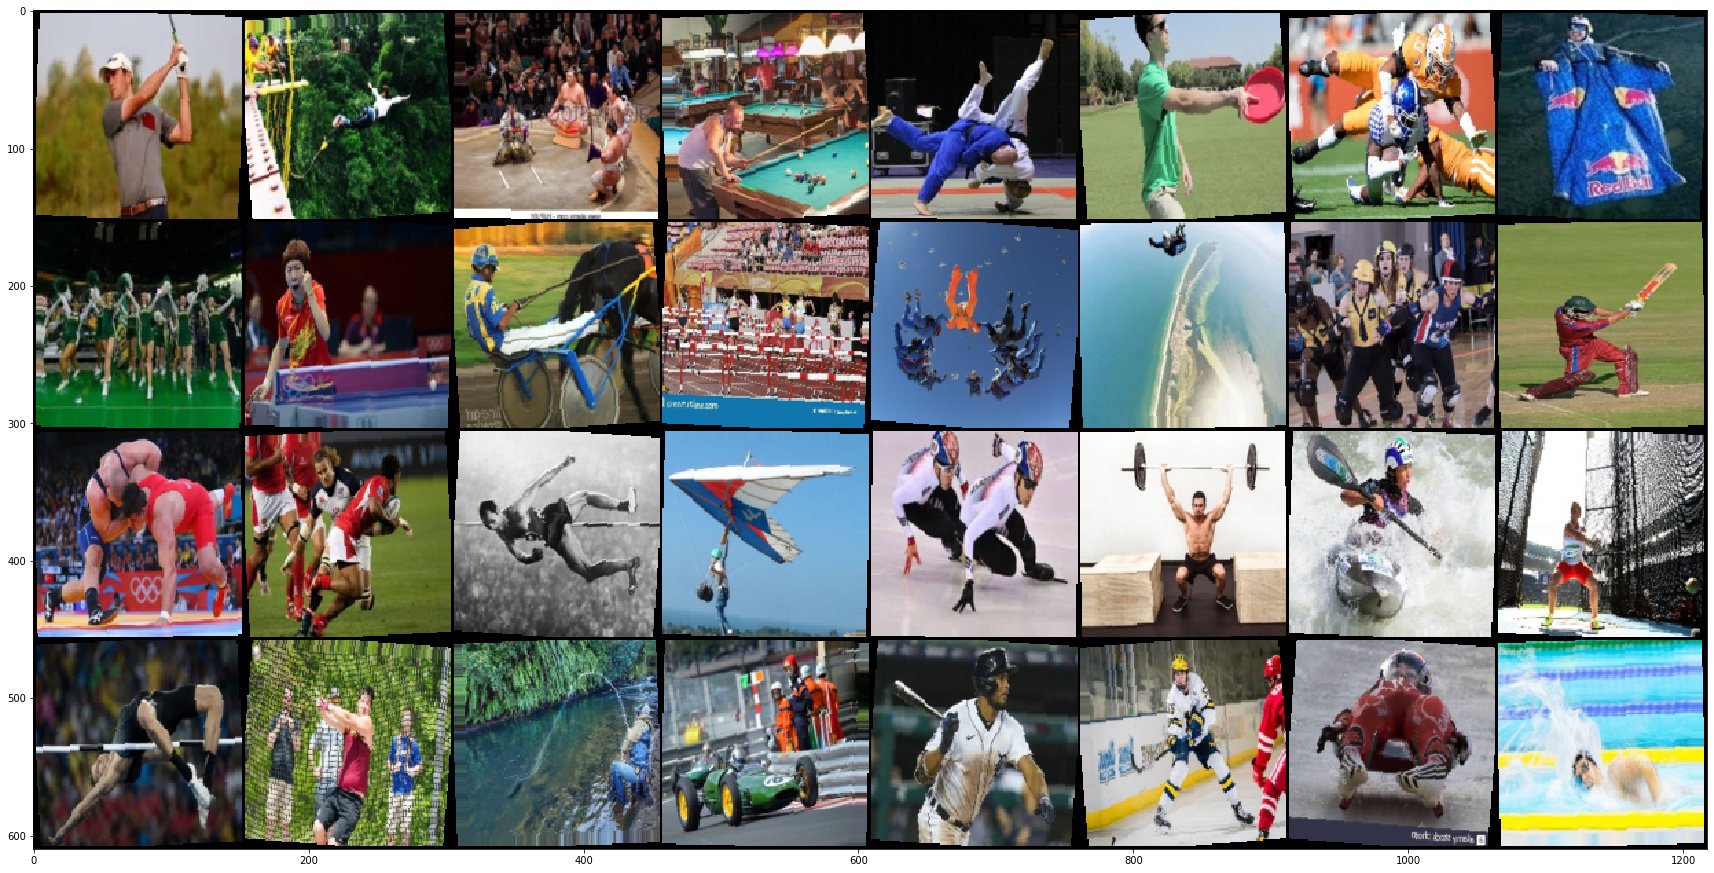

Labels 1:     golf, bungee jumping, sumo wrestling, billiards,      judo,   frisbee,  football, wingsuit flying
Labels 2:cheerleading, table tennis, harness racing,   hurdles, skydiving, skydiving, roller derby,   cricket
Labels 3:olympic wrestling,     rugby, high jump, hang gliding, speed skating, weightlifting, canoe slamon, hammer throw
Labels 4:high jump, hammer throw, fly fishing, formula 1 racing,  baseball,    hockey,      luge,  swimming


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:32]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize = (30,300))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels 1:" + ', '.join('%9s' % data['class_dict']['class'][labels[j].item()] for j in range(8)))
print("Labels 2:" + ', '.join('%9s' % data['class_dict']['class'][labels[j].item()] for j in range(8,16)))
print("Labels 3:" + ', '.join('%9s' % data['class_dict']['class'][labels[j].item()] for j in range(16,24)))
print("Labels 4:" + ', '.join('%9s' % data['class_dict']['class'][labels[j].item()] for j in range(24,32)))

## The Training Function ###

This training function is pulled straigt out of Joseph Redmon's PyTorch tutorial series (see his explanation below). I choose to use this because of its built in ability to 1) Save models after each epoch and 2) allow training to begin from saved model. This was very useful for when I did not have access to the GPU and had models crash 2 hours into training. 

Train Explanation:

Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [5]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [6]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

## Accuracy Function

Once we train a model, we want to asses its performance to see how well it actually works. I created this accuracy function to 1) calculate the accuracy of the model net on the dataset from dataloader, but 2) it also will create a .csv file that records the prediction and the actual label for each image if you provide filename ofname. This allows you to go over each prediction and see how close it was, or even note the categories it hasn't quite learned yet. Note that this function is under the assumtion the batch size is 1.

In [7]:
# Prediction
def accuracy(net, dataloader, ofname=None):
    # If filename defined, set up out to write to
    if ofname:
      out = open(ofname, 'w')
      out.write("path, pred class, actual\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    print("Beginning Accuracy Test:")
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device) # get current image and label
            outputs = net(images) # Forward propogate image through network
            _, predicted = torch.max(outputs.data, 1) # get most likely label
            fname, _ = dataloader.dataset.samples[i]
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # if correct prediction add to correct
            # If adding to file, add both the predicted label and actual label
            if ofname:
              out.write("test/{},{},{}\n".format(fname.split('/')[-1], data['class_dict']['class'][predicted.item()], data['class_dict']['class'][labels.item()]))
    if ofname:
      out.close()
    return correct/total # return final accuracy

## First Model Attempt

As a first try to classify the dataset, we will use a very simple model. This will give us some insight on how complex the dataset is, and will provide a baseline accuracy score that we can work to improve (or just be done if it can easily learn the dataset).

This simple model is called SimpleNet, and is a very vanilla Neural Network with a single hidden layer using leak relu activation. As our input images are (3 x 150 x 150) the input size will be 67500, and as we are predicting 100 different classes, our output size will be 100. With a hidden layer size of 512, there will be 34,611,200 (67500x512 + 512x100) different weights in the model. This will take forever to run with a laptop CPU (3+ hours, believe me I tried) so it is recommended you use GPU.

In [6]:
class SimpleNet(nn.Module):
    # 67500 for 3x150x150, 100 category outputs
    def __init__(self, inputs=67500, hidden=512, outputs=100):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1) # Takes image-like to vector-like
        x = self.fc1(x)
        x = F.leaky_relu(x) # leaky relu activation
        x = self.fc2(x)
        return x

## SimpleNet on Sports Images

With the GPU, the following training ran in around 15 minutes for 20 epochs. After experimenting with the learning rates, I found that starting with a 0.01 learning rate, and then moving to 0.001 after 15 epochs seemed to work well. Training seemed to struggle to get the loss down, and it ended 3.4 loss. Overall, this model achieved 20.2% test accuracy on the test set after 20 epochs.

In [ ]:
simplenet = SimpleNet()
simple_losses = train(simplenet, data['train'], epochs=20, schedule={0:.01, 15:.001}, checkpoint_path=checkpoints)

Learning rate: 0.010000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0,    10] loss: 4.651
[0,    20] loss: 4.602
[0,    30] loss: 4.551
[0,    40] loss: 4.468
[0,    50] loss: 4.396
[0,    60] loss: 4.325
[0,    70] loss: 4.249
[0,    80] loss: 4.209
[0,    90] loss: 4.199
[0,   100] loss: 4.144
[1,    10] loss: 4.252
[1,    20] loss: 4.112
[1,    30] loss: 3.991
[1,    40] loss: 4.026
[1,    50] loss: 4.016
[1,    60] loss: 3.989
[1,    70] loss: 3.976
[1,    80] loss: 3.972
[1,    90] loss: 3.913
[1,   100] loss: 3.882
[2,    10] loss: 4.206
[2,    20] loss: 3.990
[2,    30] loss: 3.989
[2,    40] loss: 3.942
[2,    50] loss: 3.996
[2,    60] loss: 3.896
[2,    70] loss: 3.926
[2,    80] loss: 3.846
[2,    90] loss: 3.817
[2,   100] loss: 3.818
[3,    10] loss: 4.108
[3,    20] loss: 4.017
[3,    30] loss: 3.945
[3,    40] loss: 3.892
[3,    50] loss: 3.823
[3,    60] loss: 3.900
[3,    70] loss: 3.820
[3,    80] loss: 3.835
[3,    90] loss: 3.842
[3,   100] loss: 3.907
[4,    10] loss: 3.877
[4,    20] loss: 3.853
[4,    30] loss: 3.880
[4,    40] 

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing  accuracy: 0.202000


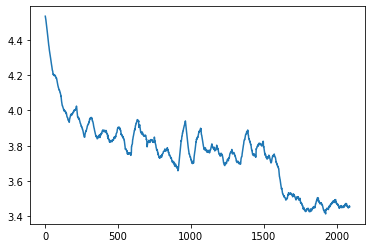

In [ ]:
plt.plot(smooth(simple_losses,50))
print("Testing  accuracy: %f" % accuracy(simplenet, data['test']))

### Testing the saved model
This model is saved in the file: checkpoints + 'simple20.pkl'. You can load the model and check its performance yourself using:

In [ ]:
# Load model from checkpoint
simple_checkpoint = SimpleNet()

# Bring in loaded 
state = torch.load(checkpoints + 'simple20.pkl')
simple_checkpoint.load_state_dict(state['net'])

print("Testing accuracy: %f" % accuracy(simple_checkpoint, data['test'], ofname=checkpoints + "simple20Preds.csv"))

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing accuracy: 0.202000


## A Better Approach

After seeing the simple model only get up to around 20% accuracy, we can definitely do better. Now we will take advantage of convolutions, batch normalization, and pooling to greatly reduce the size of the network and take advantage of the structure of our images. Here we will use the [Darknet architecture](https://pjreddie.com/darknet/imagenet/#reference) also introduced in Redmon's tutorial. Basically, there are 5 sets of convolutions followed by batch normalization, and then a global average pooling step to produce a lenth 256 vector feature map, and then a fully connected final layer.

In [19]:
class Darknet64(nn.Module):
    def __init__(self):
        super(Darknet64, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 100)

    def forward(self, x):
        # Input 150x150x3
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=3) # Stride 3 reduce size to 50x50x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # Stride 2 size now: 25x25x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # Stride 2 size now: 13x13x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # Size now: 7x7x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # Finally size: 4x4x256

        # Global average pooling across each channel (Regardless of first two dimensions, output is always be 256 length vector)
        x = F.adaptive_avg_pool2d(x, 1) # size(x) = [128, 256, 1, 1]               # 1x1x256
        x = torch.flatten(x, 1)         # size(x) = [128, 256]                     # vector 256
        
        x = self.fc1(x)
        return x


## DarkNet on Sports Images

With the GPU, the following training ran in around 15 minutes for 20 epochs. After experimenting with the learning rates, I found that starting with a 0.1 learning rate, moving to 0.01 after 5 epochs, and then ending at 0.001 after 15 epochs seemed to work well. Training was able to get the loss much lower than the previous attempt and continued to get lower throughout the process ending at 1.2. Overall, this model achieved 66.4% accuracy on the test set after 20 epochs. Interestingly, the model gets 67.0% accuracy after 17 epochs. Both models are saved and can be loaded (see below).

In [ ]:
convnet = Darknet64()
conv_losses = train(convnet, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Learning rate: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0,    10] loss: 4.575
[0,    20] loss: 4.310
[0,    30] loss: 4.055
[0,    40] loss: 4.002
[0,    50] loss: 3.864
[0,    60] loss: 3.713
[0,    70] loss: 3.599
[0,    80] loss: 3.521
[0,    90] loss: 3.419
[0,   100] loss: 3.355
[1,    10] loss: 3.658
[1,    20] loss: 3.516
[1,    30] loss: 3.238
[1,    40] loss: 3.170
[1,    50] loss: 3.059
[1,    60] loss: 3.044
[1,    70] loss: 3.012
[1,    80] loss: 2.932
[1,    90] loss: 2.999
[1,   100] loss: 2.900
[2,    10] loss: 3.086
[2,    20] loss: 3.050
[2,    30] loss: 2.878
[2,    40] loss: 2.791
[2,    50] loss: 2.704
[2,    60] loss: 2.653
[2,    70] loss: 2.698
[2,    80] loss: 2.542
[2,    90] loss: 2.632
[2,   100] loss: 2.609
[3,    10] loss: 3.022
[3,    20] loss: 2.767
[3,    30] loss: 2.653
[3,    40] loss: 2.532
[3,    50] loss: 2.327
[3,    60] loss: 2.418
[3,    70] loss: 2.319
[3,    80] loss: 2.344
[3,    90] loss: 2.379
[3,   100] loss: 2.325
[4,    10] loss: 2.766
[4,    20] loss: 2.458
[4,    30] loss: 2.322
[4,    40] 

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing  accuracy: 0.664000


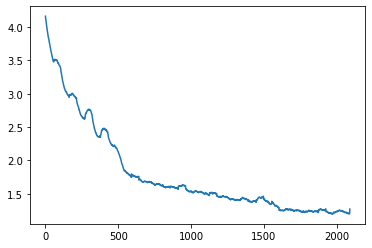

In [ ]:
plt.plot(smooth(conv_losses,50))
print("Testing  accuracy: %f" % accuracy(convnet, data['test']))

### Testing the saved model
This model is saved in the files: checkpoints + 'convnet17.pkl' and checkpoints + 'convnet20.pkl'. You can load either model and check its performance yourself using:

In [ ]:
# Load model from checkpoint
checkpoint_conv = Darknet64()

# Bring in loaded 
state = torch.load(checkpoints + 'convnet17.pkl')
checkpoint_conv.load_state_dict(state['net'])

print("Testing accuracy: %f" % accuracy(checkpoint_conv, data['test'], ofname=checkpoints + "convnet17Preds.csv"))

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing accuracy: 0.670000


## Pretraining For the Win

Getting up to 67% is a large improvement from the initial 20%, but we can still do much better. This leads us to pretraining. Why try to reinvent the wheel? PyTorch allows us to download architectures already trained on a harder image data set, ImageNet, and then we can modify the final fully connected layer to fit our own dataset. Finally, we can train the pretrained network on our own training dataset. 

For these last three models, I use the resnet18 pretrained model, as well as the efficientnet_b0. For the first attempt with Pretrained networks, I will use the resnet18 architecture with no modifications to the augmentation of the dataset

## ResNet on Sports Images

With the GPU, the following training ran in around 18 minutes for 20 epochs. After experimenting with the learning rates, I found that starting with a 0.1 learning rate, moving to 0.01 after 5 epochs, and then ending at 0.001 after 15 epochs seemed to work well. Training did very well and was able to bring the loss down to 0.1. Overall, this model achieved 92.2% accuracy on the test set after 20 epochs.

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
# Need to map the final layer to exactly 100 categories for each sport
resnet.fc = nn.Linear(512, 100)

# Make a schedule
res_losses = train(resnet, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0,    10] loss: 4.271
[0,    20] loss: 3.605
[0,    30] loss: 3.734
[0,    40] loss: 3.886
[0,    50] loss: 3.942
[0,    60] loss: 3.847
[0,    70] loss: 3.479
[0,    80] loss: 3.185
[0,    90] loss: 2.815
[0,   100] loss: 2.646
[1,    10] loss: 3.735
[1,    20] loss: 2.987
[1,    30] loss: 2.665
[1,    40] loss: 2.147
[1,    50] loss: 2.017
[1,    60] loss: 1.880
[1,    70] loss: 1.808
[1,    80] loss: 1.731
[1,    90] loss: 1.706
[1,   100] loss: 1.627
[2,    10] loss: 2.437
[2,    20] loss: 2.153
[2,    30] loss: 1.854
[2,    40] loss: 1.629
[2,    50] loss: 1.567
[2,    60] loss: 1.503
[2,    70] loss: 1.412
[2,    80] loss: 1.394
[2,    90] loss: 1.369
[2,   100] loss: 1.295
[3,    10] loss: 1.768
[3,    20] loss: 1.402
[3,    30] loss: 1.266
[3,    40] loss: 1.195
[3,    50] loss: 1.156
[3,    60] loss: 1.230
[3,    70] loss: 1.144
[3,    80] loss: 1.117
[3,    90] loss: 1.024
[3,   100] loss: 1.099
[4,    10] loss: 1.335
[4,    20] loss: 1.216
[4,    30] loss: 1.036
[4,    40] 

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing  accuracy: 0.922000


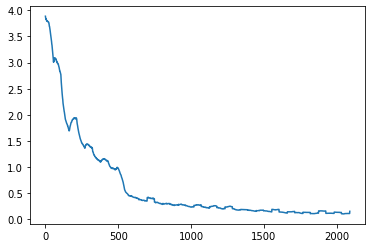

In [ ]:
plt.plot(smooth(res_losses,50))
print("Testing  accuracy: %f" % accuracy(resnet, data['test']))

### Testing the saved model
This model is saved in the files: checkpoints + 'resnet20.pkl'. You can load the model and check its performance yourself using:

In [ ]:
# Load model from checkpoint
checkpoint_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
checkpoint_model.fc = nn.Linear(512, 100) # This will reinitialize the layer as well

# Bring in loaded 
state = torch.load(checkpoints + 'resnet20.pkl')
checkpoint_model.load_state_dict(state['net'])

print("Testing accuracy: %f" % accuracy(checkpoint_model, data['test'], ofname=checkpoints + "resnet20Preds.csv"))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing accuracy: 0.922000


## Modified Augmentation
Finally, I wanted to experiment with different augmentations to see how they effected the models performance. For the next model, we will use the same architecture as above (pretrained resnet18), but instead of random rotate and adding noise, we will only perform the random crop, flip, and normalize the images. Further explanation of this augmentation is explained in 'Loading the Data' section.

## ResNetv2 on Sports Images

With the GPU, the following training ran in around 17 minutes for 20 epochs. I used the same learning rate schedule as above, and training did very well and was able to bring the loss down to 0.015, even better than the previous. Overall, this model achieved 94.6% accuracy on the test set after 20 epochs.

In [ ]:
resnet2 = models.resnet18(pretrained=True)
# Need to map the final layer to exactly 100 categories for each sport
resnet2.fc = nn.Linear(512, 100)

# Make a schedule
res2_losses = train(resnet2, data['train'], epochs=20, schedule={0:.01, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Learning rate: 0.010000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0,    10] loss: 4.592
[0,    20] loss: 3.830
[0,    30] loss: 2.977
[0,    40] loss: 2.322
[0,    50] loss: 1.745
[0,    60] loss: 1.448
[0,    70] loss: 1.212
[0,    80] loss: 1.115
[0,    90] loss: 0.994
[0,   100] loss: 0.838
[1,    10] loss: 0.805
[1,    20] loss: 0.674
[1,    30] loss: 0.597
[1,    40] loss: 0.549
[1,    50] loss: 0.510
[1,    60] loss: 0.519
[1,    70] loss: 0.524
[1,    80] loss: 0.476
[1,    90] loss: 0.466
[1,   100] loss: 0.495
[2,    10] loss: 0.586
[2,    20] loss: 0.463
[2,    30] loss: 0.409
[2,    40] loss: 0.373
[2,    50] loss: 0.337
[2,    60] loss: 0.336
[2,    70] loss: 0.312
[2,    80] loss: 0.274
[2,    90] loss: 0.306
[2,   100] loss: 0.288
[3,    10] loss: 0.331
[3,    20] loss: 0.249
[3,    30] loss: 0.263
[3,    40] loss: 0.219
[3,    50] loss: 0.208
[3,    60] loss: 0.207
[3,    70] loss: 0.216
[3,    80] loss: 0.194
[3,    90] loss: 0.196
[3,   100] loss: 0.192
[4,    10] loss: 0.187
[4,    20] loss: 0.167
[4,    30] loss: 0.160
[4,    40] 

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing  accuracy: 0.946000


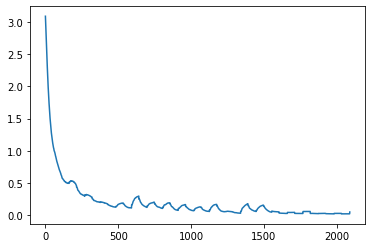

In [ ]:
plt.plot(smooth(res2_losses,50))
print("Testing  accuracy: %f" % accuracy(resnet2, data['test']))

### Testing the saved model
This model is saved in the files: checkpoints + 'resnetv20.pkl'. You can load the model and check its performance yourself using:

In [ ]:
# Load model from checkpoint
checkpoint_resnet2 = models.resnet18(pretrained=True)
# Need to map the final layer to exactly 100 categories for each sport
checkpoint_resnet2.fc = nn.Linear(512, 100)

# Bring in loaded 
state = torch.load(checkpoints + 'resnetv20.pkl')
checkpoint_resnet2.load_state_dict(state['net'])

print("Testing accuracy: %f" % accuracy(checkpoint_resnet2, data['test'], ofname=checkpoints + "resnetv20Preds.csv"))

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing accuracy: 0.946000


## EffNet on Sports Images

For a further comparison, we will try a different pretrained model to see how it compares to resnet18. As the second set of augmentations produced better results, we will also use it for this efficientnet model. Note that this means the test set also needs to be normalized.



With the GPU, the following training ran in around 15 minutes for 20 epochs. I used the same learning rates as above, and the training did very well and was able to bring the loss down to 0.018, around the same as the previous. Overall, this model achieved 95.6% accuracy on the test set after 20 epochs. Interestingly, the model gets 95.8% accuracy after 17 epochs. Both models are saved and can be loaded (see below).

In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

efficientnet.fc = nn.Linear(512, 100)

# Make a schedule
eff_losses = train(efficientnet, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Learning rate: 0.100000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0,    10] loss: 6.858
[0,    20] loss: 4.407
[0,    30] loss: 2.750
[0,    40] loss: 1.868
[0,    50] loss: 1.453
[0,    60] loss: 1.188
[0,    70] loss: 1.257
[0,    80] loss: 1.157
[0,    90] loss: 1.044
[0,   100] loss: 0.876
[1,    10] loss: 0.897
[1,    20] loss: 0.856
[1,    30] loss: 0.765
[1,    40] loss: 0.773
[1,    50] loss: 0.673
[1,    60] loss: 0.619
[1,    70] loss: 0.588
[1,    80] loss: 0.651
[1,    90] loss: 0.633
[1,   100] loss: 0.549
[2,    10] loss: 0.690
[2,    20] loss: 0.606
[2,    30] loss: 0.461
[2,    40] loss: 0.440
[2,    50] loss: 0.421
[2,    60] loss: 0.352
[2,    70] loss: 0.405
[2,    80] loss: 0.401
[2,    90] loss: 0.333
[2,   100] loss: 0.381
[3,    10] loss: 0.290
[3,    20] loss: 0.261
[3,    30] loss: 0.230
[3,    40] loss: 0.214
[3,    50] loss: 0.216
[3,    60] loss: 0.219
[3,    70] loss: 0.274
[3,    80] loss: 0.248
[3,    90] loss: 0.239
[3,   100] loss: 0.229
[4,    10] loss: 0.433
[4,    20] loss: 0.425
[4,    30] loss: 0.350
[4,    40] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf387c9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf387c9950>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf387c9950>
    if w.is_alive():
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faf387c9950>
  File 

[16,    10] loss: 0.017
[16,    20] loss: 0.013
[16,    30] loss: 0.017
[16,    40] loss: 0.013
[16,    50] loss: 0.013
[16,    60] loss: 0.012
[16,    70] loss: 0.017
[16,    80] loss: 0.015
[16,    90] loss: 0.014
[16,   100] loss: 0.018
[17,    10] loss: 0.014
[17,    20] loss: 0.018
[17,    30] loss: 0.014
[17,    40] loss: 0.016
[17,    50] loss: 0.016
[17,    60] loss: 0.015
[17,    70] loss: 0.013
[17,    80] loss: 0.015
[17,    90] loss: 0.021
[17,   100] loss: 0.015
[18,    10] loss: 0.016
[18,    20] loss: 0.013
[18,    30] loss: 0.012
[18,    40] loss: 0.017
[18,    50] loss: 0.012
[18,    60] loss: 0.010
[18,    70] loss: 0.019
[18,    80] loss: 0.013
[18,    90] loss: 0.014
[18,   100] loss: 0.015
[19,    10] loss: 0.018
[19,    20] loss: 0.013
[19,    30] loss: 0.017
[19,    40] loss: 0.014
[19,    50] loss: 0.011
[19,    60] loss: 0.014
[19,    70] loss: 0.013
[19,    80] loss: 0.015
[19,    90] loss: 0.012
[19,   100] loss: 0.018


Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing  accuracy: 0.956000


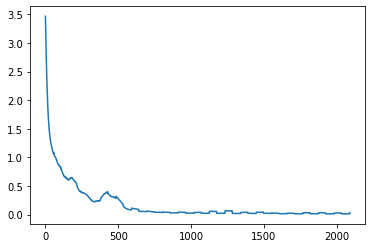

In [ ]:
plt.plot(smooth(eff_losses,50))
print("Testing  accuracy: %f" % accuracy(efficientnet, data['test']))

### Testing the saved model
This model is saved in the files: checkpoints + 'effnet17.pkl' and checkpoints + 'effnet20.pkl'. You can load either model and check its performance yourself using:

In [ ]:
# Load model from checkpoint
checkpoint_eff = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
checkpoint_eff.fc = nn.Linear(512, 100) # This will reinitialize the layer as well

# Bring in loaded 
state = torch.load(checkpoints + 'effnet17.pkl')
checkpoint_eff.load_state_dict(state['net'])

print("Testing accuracy: %f" % accuracy(checkpoint_eff, data['test'], ofname=checkpoints + "effnet17Preds.csv"))

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Testing accuracy: 0.958000


## Comparison of the Models

After spending such a large amount of time tweaking and training the models, let's compare their performance. First we will load each of the best models:

In [8]:
# Load all of the models here
# Simple Model
simple = SimpleNet()
state1 = torch.load(checkpoints + 'simple20.pkl', map_location=torch.device('cpu'))
simple.load_state_dict(state1['net'])

# Convnet
convnet = Darknet64()
state2 = torch.load(checkpoints + 'convnet17.pkl', map_location=torch.device('cpu'))
convnet.load_state_dict(state2['net'])

# Resnet1
resv1 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resv1.fc = nn.Linear(512, 100) # This will reinitialize the layer as well
state3 = torch.load(checkpoints + 'resnet20.pkl', map_location=torch.device('cpu'))
resv1.load_state_dict(state3['net'])

# Resnet2
resnetv2 = models.resnet18(pretrained=True)
resnetv2.fc = nn.Linear(512, 100)
state4 = torch.load(checkpoints + 'resnetv20.pkl', map_location=torch.device('cpu'))
resnetv2.load_state_dict(state4['net'])

# EfficientNet
effnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
effnet.fc = nn.Linear(512, 100) # This will reinitialize the layer as well
state5 = torch.load(checkpoints + 'effnet20.pkl', map_location=torch.device('cpu'))
effnet.load_state_dict(state5['net'])


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

<All keys matched successfully>

We find the following test set accuracies below:
Simple accuracy: 20.2%, Convnet accuracy 67%, Resnetv1 accuracy 92.2%, Resnetv2 accuracy 94.6%, Effnet accuracy 95.8%.


Note: Resnetv2 and Effnet need data['test'] to be normalized to reach this accuracy.

In [13]:
print("Simple accuracy: %f" % accuracy(simple, data['test']))
print("Convnet accuracy: %f" % accuracy(convnet, data['test']))
print("Resnetv1 accuracy: %f" % accuracy(resv1, data['test']))
print("Resnetv2 accuracy: %f" % accuracy(resnetv2, data['test']))
print("Effnet accuracy: %f" % accuracy(effnet, data['test']))

Beginning Accuracy Test:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
100
200
300
400
Simple accuracy: 0.202000
Beginning Accuracy Test:
0
100
200
300
400
Convnet accuracy: 0.670000
Beginning Accuracy Test:
0
100
200
300
400
Resnetv1 accuracy: 0.922000
Beginning Accuracy Test:
0
100
200
300
400
Resnetv2 accuracy: 0.868000
Beginning Accuracy Test:
0
100
200
300
400
Effnet accuracy: 0.934000


## Comparison Function
This method takes in a dataloader, and booleans real_label and num, and then outputs num images from the dataloader with each models prediction and the real label of the image if real_label = 1. This function allows you to pass in any dataloader including outstide images (such as the realworld set) to compare how the classify different types of images

In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# Tensors and transform for normalization
std=torch.Tensor([0.4687, 0.4667, 0.4540])
mean=torch.Tensor([0.2792, 0.2717, 0.2852])
norm = transforms.Compose([
    transforms.Normalize(mean,std)
])

crop = transforms.Compose([
    transforms.CenterCrop(150)
])

def compare(dataloader, real_label, num):
  # Ensure all of the networks are accessible
  simple.to(device)
  convnet.to(device)
  resv1.to(device)
  resnetv2.to(device)
  effnet.to(device)

  # Put all networks in eval() mode so they produce the correct predictions
  simple.eval()
  convnet.eval()
  resv1.eval()
  resnetv2.eval()
  effnet.eval()

  with torch.no_grad():
          for i, (images, labels) in enumerate(dataloader, 0):
            if i > num:
              break
            images, labels = images.to(device), labels.to(device)
            # Show the image being predicted
            imshow(torchvision.utils.make_grid(images.cpu()))
            # Crop image
            images = crop(images)
            # Get the results from the first three neworks
            output1 = simple(images)
            output2 = convnet(images)
            output3 = resv1(images)
            # Normalize the pictures for the last two networks
            images = norm(images)
            output4 = resnetv2(images)
            output5 = effnet(images)
            # Store each networks predicted index
            _, predicted1 = torch.max(output1.data, 1)
            _, predicted2 = torch.max(output2.data, 1)
            _, predicted3 = torch.max(output3.data, 1)
            _, predicted4 = torch.max(output4.data, 1)
            _, predicted5 = torch.max(output5.data, 1)
            # print all of the labels
            if real_label == 1:
              print("Real Label:" + ''.join('%9s' % data['class_dict']['class'][labels.item()]))
            print("Simple Prediction:" + ''.join('%9s' % data['class_dict']['class'][predicted1.item()]))
            print("Convnet Prediction:" + ''.join('%9s' % data['class_dict']['class'][predicted2.item()]))
            print("Resnetv1 Prediction:" + ''.join('%9s' % data['class_dict']['class'][predicted3.item()]))
            print("Resnetv2 Prediction:" + ''.join('%9s' % data['class_dict']['class'][predicted4.item()]))
            print("Effnet Prediction:" + ''.join('%9s' % data['class_dict']['class'][predicted5.item()]))

## Compare on Validation
Try it out yourself!!!

Generally, we find there are a few images that all models are able to classify correctly, but other than that the Simple Model is generally way off. Convnet also gets a few more wrong, and then the 3 pretrained are quite similar with their guesses. However, after a couple tries I have encountered situations where one of the three pretrained predictions differs from the others, showing that they indeed learned different features.

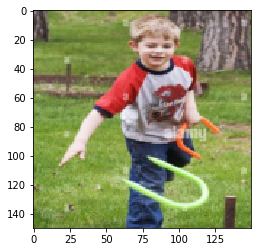

Real Label:horseshoe pitching
Simple Prediction:  croquet
Convnet Prediction:  frisbee
Resnetv1 Prediction: lacrosse
Resnetv2 Prediction:  frisbee
Effnet Prediction:  frisbee


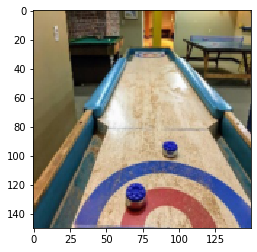

Real Label:shuffleboard
Simple Prediction:arm wrestling
Convnet Prediction:     judo
Resnetv1 Prediction:shuffleboard
Resnetv2 Prediction:shuffleboard
Effnet Prediction:shuffleboard


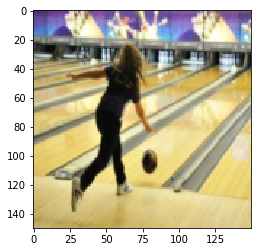

Real Label:  bowling
Simple Prediction:  croquet
Convnet Prediction:  bowling
Resnetv1 Prediction:  bowling
Resnetv2 Prediction:  bowling
Effnet Prediction:  bowling


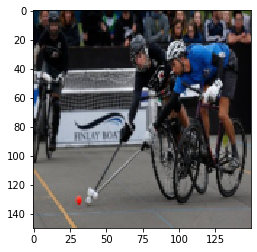

Real Label:bike polo
Simple Prediction:basketball
Convnet Prediction:harness racing
Resnetv1 Prediction:bike polo
Resnetv2 Prediction:bike polo
Effnet Prediction:bike polo


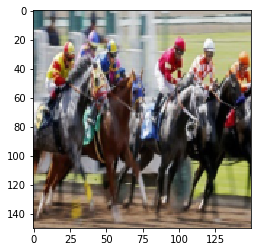

Real Label:horse racing
Simple Prediction:horse racing
Convnet Prediction:horse racing
Resnetv1 Prediction:horse racing
Resnetv2 Prediction:horse racing
Effnet Prediction:horse racing


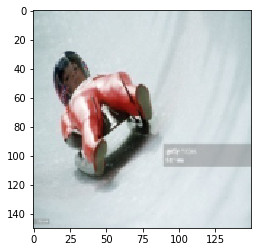

Real Label:     luge
Simple Prediction:   rowing
Convnet Prediction:     luge
Resnetv1 Prediction:     luge
Resnetv2 Prediction:     luge
Effnet Prediction:     luge


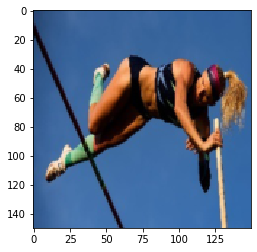

Real Label:pole vault
Simple Prediction:water polo
Convnet Prediction:pole vault
Resnetv1 Prediction:pole vault
Resnetv2 Prediction:high jump
Effnet Prediction:pole vault


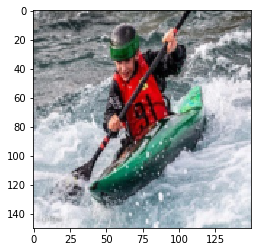

Real Label:canoe slamon
Simple Prediction:figure skating men
Convnet Prediction:canoe slamon
Resnetv1 Prediction:canoe slamon
Resnetv2 Prediction:canoe slamon
Effnet Prediction:canoe slamon


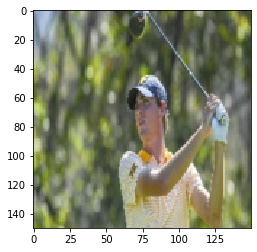

Real Label:     golf
Simple Prediction:  croquet
Convnet Prediction:bungee jumping
Resnetv1 Prediction:     golf
Resnetv2 Prediction:     golf
Effnet Prediction:     golf


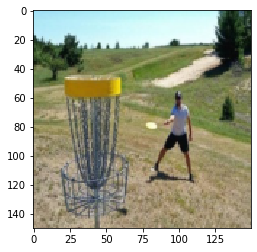

Real Label:disc golf
Simple Prediction:harness racing
Convnet Prediction:disc golf
Resnetv1 Prediction:disc golf
Resnetv2 Prediction:disc golf
Effnet Prediction:disc golf


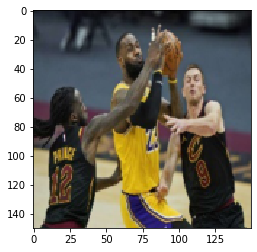

Real Label:basketball
Simple Prediction:basketball
Convnet Prediction:basketball
Resnetv1 Prediction:basketball
Resnetv2 Prediction:basketball
Effnet Prediction:basketball


In [10]:
compare(data['valid'], 1, 10)

## Real World Application

Finally, I wanted to see how the models could do off in the real world. I have compiled the set of images 'real_world' which are a set of 20 images of me doing a bunch of different activites. These include photos of me playing football and baseball in high school (and even T-ball), kayaking, paddle boarding and surfing, and other photos of me and my friends posing for a photo on a basketball court, football field, or golf course.

As these are much different from the testing set, it makes sense that the models don't do great. I have found that the action shots for football and baseball are classified pretty well by all of the models. However, there is a lot of confusion for the photos where we are just standing and posing. 

Overall, it is really cool to see how each model's learning transfers to a different set in the real world.

Try it on your own!! Upload some of your own images to the set and see how your models do!!

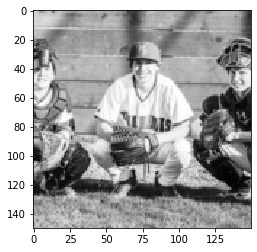

Simple Prediction:hammer throw
Convnet Prediction:sailboat racing
Resnetv1 Prediction:hammer throw
Resnetv2 Prediction:chuckwagon racing
Effnet Prediction:bull riding


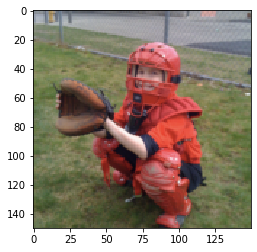

Simple Prediction: football
Convnet Prediction:wingsuit flying
Resnetv1 Prediction:pole climbing
Resnetv2 Prediction:horseshoe pitching
Effnet Prediction:pole climbing


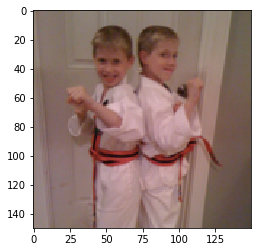

Simple Prediction:basketball
Convnet Prediction:pole dancing
Resnetv1 Prediction:table tennis
Resnetv2 Prediction:horseshoe pitching
Effnet Prediction:baton twirling


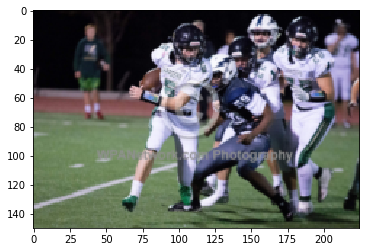

Simple Prediction: lacrosse
Convnet Prediction: lacrosse
Resnetv1 Prediction: lacrosse
Resnetv2 Prediction: football
Effnet Prediction:    rugby


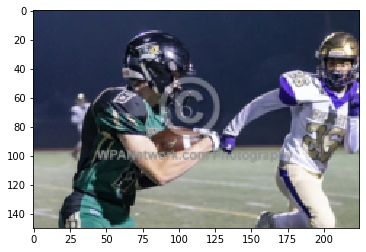

Simple Prediction:figure skating women
Convnet Prediction: football
Resnetv1 Prediction: lacrosse
Resnetv2 Prediction:weightlifting
Effnet Prediction: football


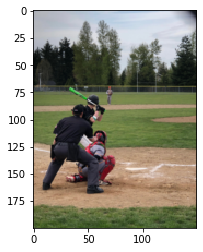

Simple Prediction:harness racing
Convnet Prediction: baseball
Resnetv1 Prediction: baseball
Resnetv2 Prediction: baseball
Effnet Prediction: baseball


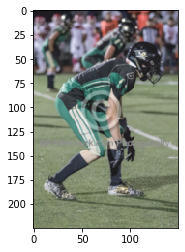

Simple Prediction:bungee jumping
Convnet Prediction:ampute football
Resnetv1 Prediction: ultimate
Resnetv2 Prediction: football
Effnet Prediction: football


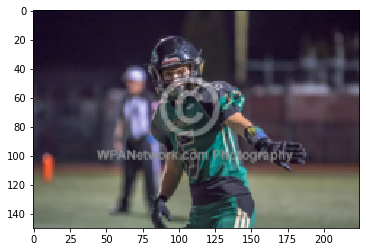

Simple Prediction:olympic wrestling
Convnet Prediction: football
Resnetv1 Prediction: football
Resnetv2 Prediction: football
Effnet Prediction: football


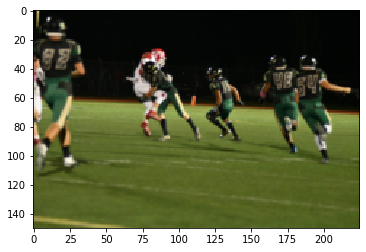

Simple Prediction:  croquet
Convnet Prediction: ultimate
Resnetv1 Prediction:     polo
Resnetv2 Prediction: football
Effnet Prediction: football


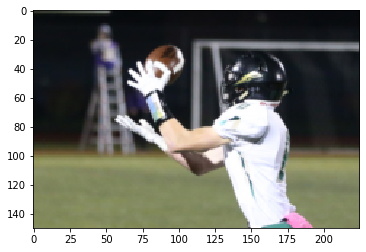

Simple Prediction:  fencing
Convnet Prediction: football
Resnetv1 Prediction: football
Resnetv2 Prediction: football
Effnet Prediction:   tennis


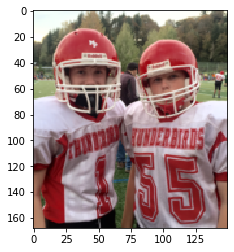

Simple Prediction:pole dancing
Convnet Prediction:  hurdles
Resnetv1 Prediction:nascar racing
Resnetv2 Prediction:   hockey
Effnet Prediction:   hockey


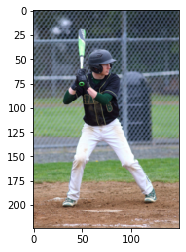

Simple Prediction:horse jumping
Convnet Prediction: baseball
Resnetv1 Prediction: baseball
Resnetv2 Prediction: baseball
Effnet Prediction: baseball


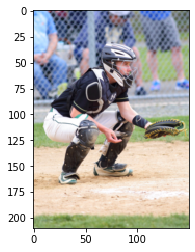

Simple Prediction:harness racing
Convnet Prediction:barell racing
Resnetv1 Prediction:rollerblade racing
Resnetv2 Prediction: baseball
Effnet Prediction:      bmx


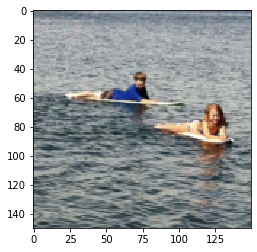

Simple Prediction:  surfing
Convnet Prediction:   rowing
Resnetv1 Prediction:   rowing
Resnetv2 Prediction:   rowing
Effnet Prediction:hydroplane racing


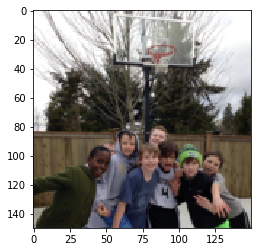

Simple Prediction:      bmx
Convnet Prediction: jousting
Resnetv1 Prediction:cheerleading
Resnetv2 Prediction:disc golf
Effnet Prediction:  archery


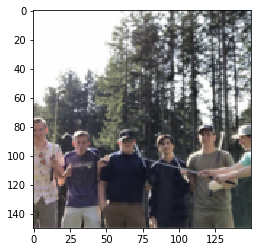

Simple Prediction:hydroplane racing
Convnet Prediction:chuckwagon racing
Resnetv1 Prediction:tug of war
Resnetv2 Prediction:tug of war
Effnet Prediction:  archery


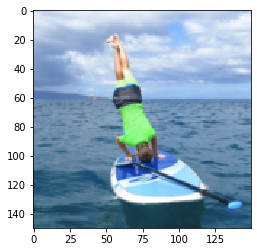

Simple Prediction:  surfing
Convnet Prediction:   rowing
Resnetv1 Prediction:  surfing
Resnetv2 Prediction:  surfing
Effnet Prediction:sailboat racing


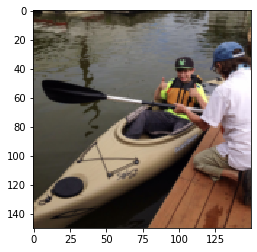

Simple Prediction: football
Convnet Prediction:horseshoe pitching
Resnetv1 Prediction:barell racing
Resnetv2 Prediction:shuffleboard
Effnet Prediction:air hockey


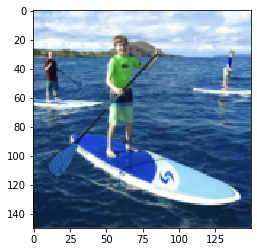

Simple Prediction:  surfing
Convnet Prediction:sailboat racing
Resnetv1 Prediction:  surfing
Resnetv2 Prediction:canoe slamon
Effnet Prediction:sailboat racing


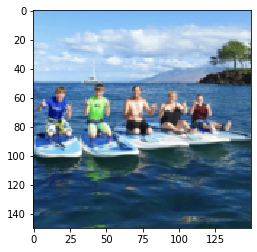

Simple Prediction:sailboat racing
Convnet Prediction:   rowing
Resnetv1 Prediction:sailboat racing
Resnetv2 Prediction:sailboat racing
Effnet Prediction:tug of war


In [13]:
compare(data['real_world'], 0, 20)